# Clasificación multiclase y Redes Neuronales

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

In [1]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import expit 

import sys

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Clasificación multiclase

Para este ejercicio, se usará regresión logística y redes neuronales para reconocer dígitos escritos a mano (de 0 a 9). El reconocimiento automático de dígitos escritos a mano se usa ampliamente en la actualidad, desde el reconocimiento de códigos postales (códigos postales) en sobres de correo hasta el reconocimiento de montos escritos en cheques bancarios. Este ejercicio  mostrará cómo los métodos que ha aprendido se pueden utilizar para esta tarea de clasificación.

La primera parte del ejercicio, extenderá la implementación anterior de la regresión logística y la aplicará a la clasificación de uno contra todos (one vs all).

### 1.1 Dataset

Se proporciona un conjunto de datos en `ex3data1.mat` que contiene 5000 ejemplos de entrenamiento de dígitos escritos a mano (este es un subconjunto del conjunto de datos de dígitos escritos a mano [MNIST] http://yann.lecun.com/exdb/mnist)). El formato `.mat` significa que los datos se han guardado en un formato de matriz nativo Octave/MATLAB, en lugar de un formato de texto (ASCII) como un archivo csv. Usamos el formato `.mat` aquí para mostrar los diferentes formatos en los que se pueden presentar los datasets. Python proporciona mecanismos para cargar el formato nativo de MATLAB usando la función `loadmat` dentro del módulo` scipy.io`. Esta función devuelve un diccionario de Python con claves que contienen los nombres de las variables dentro del archivo `.mat`.

Hay 5000 ejemplos de entrenamiento en `ex3data1.mat`, donde cada ejemplo de entrenamiento es una imagen en escala de grises de 20 píxeles por 20 píxeles del dígito. Cada píxel está representado por un número de punto flotante que indica la intensidad de la escala de grises en esa ubicación. La cuadrícula de 20 por 20 píxeles se "desenrolla" en un vector de 400 dimensiones. Cada uno de estos ejemplos de entrenamiento se convierte en una sola fila en nuestra matriz de datos "X". Esto da una matriz `X` de 5000 por 400 donde cada fila es un ejemplo de entrenamiento para una imagen de dígitos escrita a mano.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

La segunda parte del conjunto de entrenamiento es un vector "y" de 5000 dimensiones que contiene etiquetas para el conjunto de entrenamiento. 

Se inicia el ejercicio cargando primero el conjunto de datos. 

In [2]:
# Ingresar imágenes de dígitos de 28x28
input_layer_size  = 784 # Por los pixeles de cada foto

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 27 # letras del abecedario

#  datos de entrenamiento almacenados en los arreglos X, y
mat = loadmat(os.path.join('Datasets', 'emnist-letters.mat'))
# data = loadmat(os.path.join('Datasets', 'ex3data1.mat'))
# X, y = data['X'], data['y'].ravel()
# m=y.size
# # establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
# # Esto se hace debido a que el conjunto de datos se utilizó en MATLAB donde no hay índice 0

data = mat['dataset']

X = data['train'][0,0]['images'][0,0]
y = data['train'][0,0]['labels'][0,0]

X_test = data['test'][0,0]['images'][0,0]
y = data['test'][0,0]['labels'][0,0]



val_start = X.shape[0] - X_test.shape[0]
X = X[val_start:X.shape[0],:]
X = X[0:val_start,:]
y=y.ravel()
m = y.size
print(X,'\n',y)
print(m)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
 [ 1  1  1 ... 26 26 26]
20800


In [3]:
miArray = X # Creamos un array de 0 a 9 separados de uno en uno
yArray = y
ydim = yArray.ndim
numdim = miArray.ndim

Xnd = miArray.data
Ynd = yArray.data

byteX = miArray.itemsize
byteY = yArray.itemsize

print(type(miArray))
print(numdim," Numero/s de Dimenciones")
print(byteX," Numero/s totales de elementos en el array")
print(Xnd," Numero/s de Buffer de Elementos en el array")



print(type(yArray))
print(ydim," Numero/s de Dimenciones")
print(byteY," Numero/s totales de elementos en el array")
print(Ynd," Numero/s de Buffer de Elementos en el array")


<class 'numpy.ndarray'>
2  Numero/s de Dimenciones
1  Numero/s totales de elementos en el array
<memory at 0x00000230ACB25E48>  Numero/s de Buffer de Elementos en el array
<class 'numpy.ndarray'>
1  Numero/s de Dimenciones
1  Numero/s totales de elementos en el array
<memory at 0x00000230ACB45708>  Numero/s de Buffer de Elementos en el array


### 1.2 Visualización de los datos

Se comenzará visualizando un subconjunto del conjunto de entrenamiento. Se selecciona al azar, 100 filas de `X` y pasa esas filas a la función` displayData`. Esta función asigna cada fila a una imagen en escala de grises de 20 píxeles por 20 píxeles y muestra las imágenes juntas.

In [4]:
def displayData(X, example_width=None, figsize=(26, 26)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

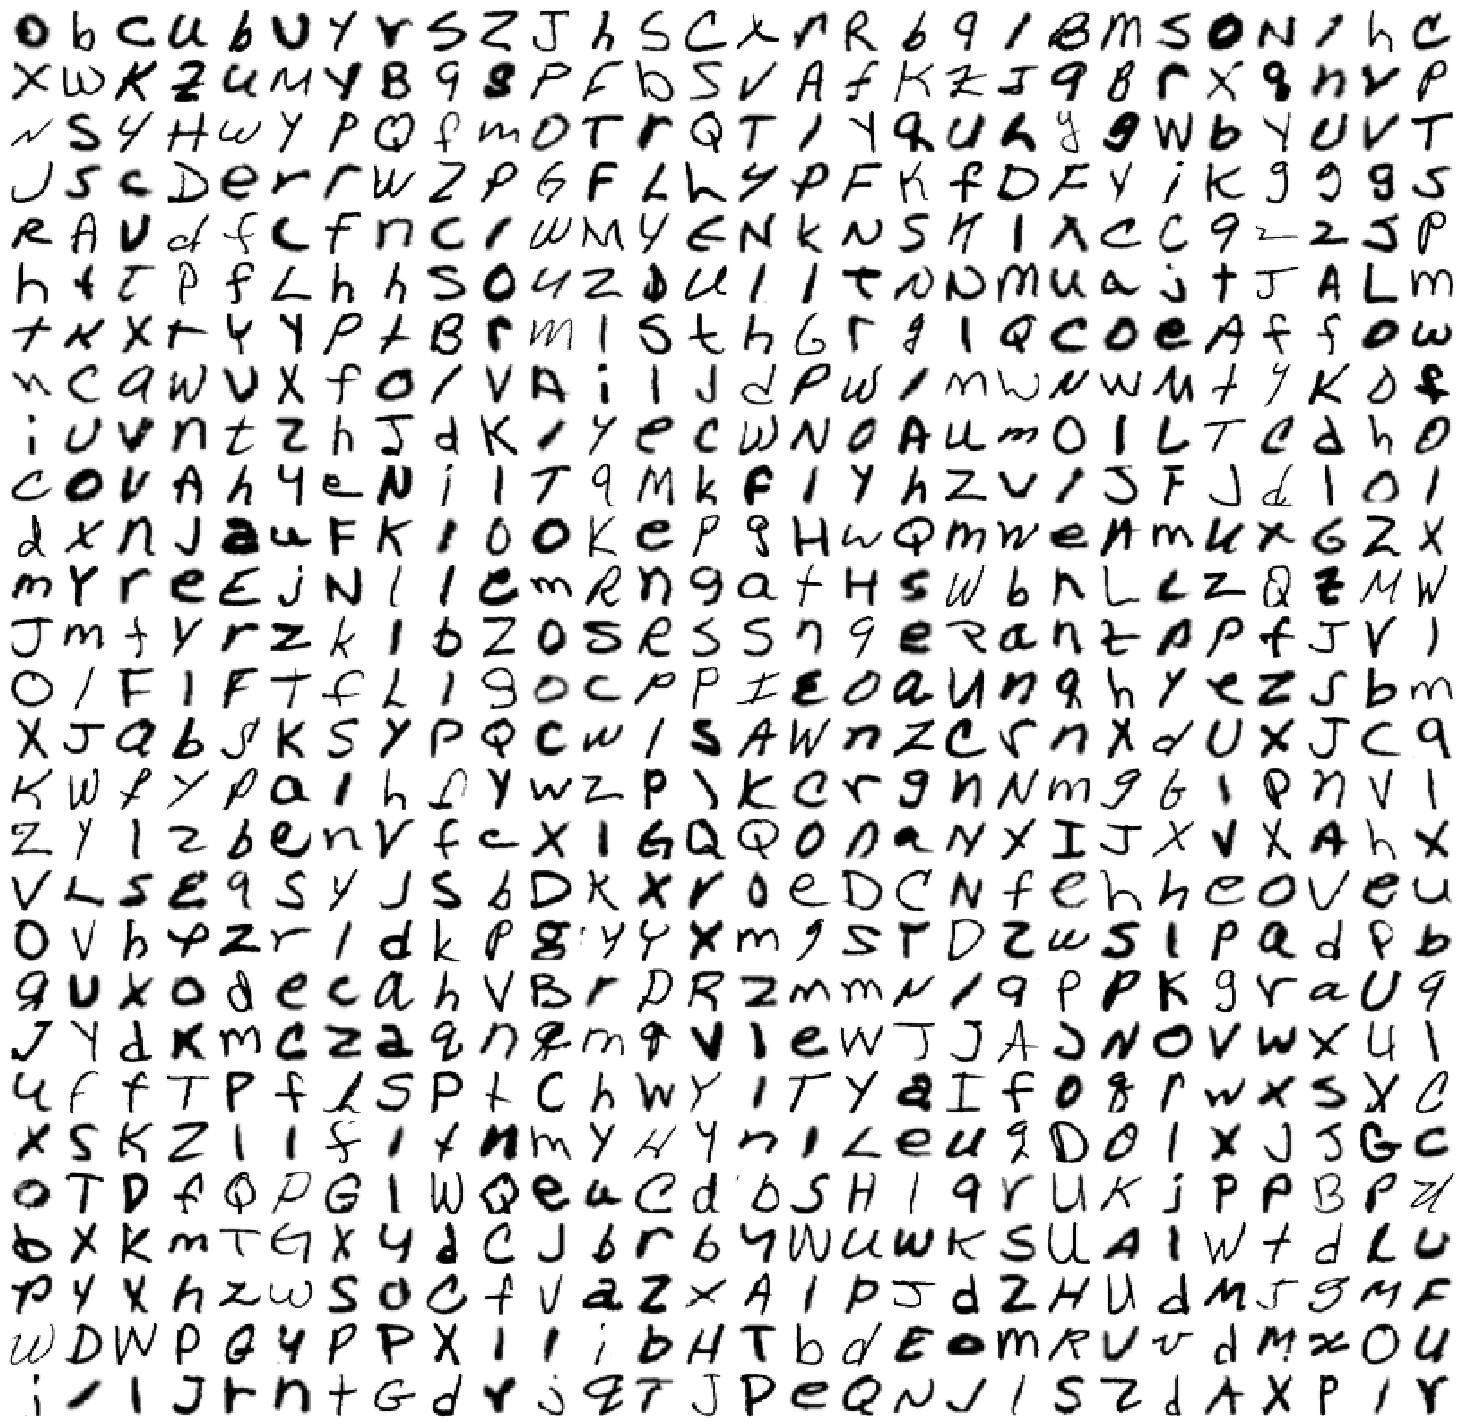

In [5]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 784, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [6]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 0.1

In [7]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    g = 1.0/(1.0 + np.exp(-z))
    g = expit(z)

    return g

In [8]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y 
    el gradiente del costo w.r.t. a los parámetros.
    
    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas 
        incluida la intercepcion
        
    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de 
        caracteristicas (incluida la intercepcion).
    
    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos
    
    lambda_ : float
        Parametro de regularización. 
    
    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada. 
    
    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la 
        función de costo con respecto a theta, en los valores actuales de theta..
    """
    # Inicializa algunos valores utiles
    m = y.size
    
    # convierte las etiquetas a valores enteros si son boleanos
    #if y.dtype == bool:
    #    y = y.astype(int)
    
    J = 0
    grad = np.zeros(theta.shape)
    
    h = sigmoid(X.dot(theta.T))
    
    temp = theta
    temp[0] = 0
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h - y).dot(X) 
    grad = grad + (lambda_ / m) * temp

    return J, grad

In [9]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo         : {:.6f}'.format(J))
print('Costo esperadot: 2.534819')
print('-----------------------')
print('Gradientes:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Gradientes esperados:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Costo         : 0.794819
Costo esperadot: 2.534819
-----------------------
Gradientes:
 [0.146561, 0.031442, 0.144722, 0.238003]
Gradientes esperados:
 [0.146561, -0.548558, 0.724722, 1.398003]


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all
En esta parte del ejercicio, se implementará la clasificación de uno contra todos mediante el entrenamiento de múltiples clasificadores de regresión logística regularizados, uno para cada una de las clases $K$ en nuestro conjunto de datos. En el conjunto de datos de dígitos escritos a mano, $K = 10$, pero su código debería funcionar para cualquier valor de $K$.

El argumento `y` de esta función es un vector de etiquetas de 0 a 9. Al entrenar el clasificador para la clase $k \in \{0, ..., K-1 \} $, querrá un vector K-dimensional de etiquetas $y$, donde $y_j \ in 0, 1$ indica si la instancia de entrenamiento $j ^ {th}$ pertenece a la clase $k$ $(y_j = 1)$, o si pertenece a una clase diferente $(y_j = 0)$.

Además, se utiliza `optimize.minimize` de scipy para este ejercicio.
<a id="oneVsAll"></a>

In [10]:
def oneVsAll(X, y, num_labels, lambda_):

    # algunas variables utiles
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 1000}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options)
        
        all_theta[c] = res.x

    return all_theta

In [11]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados. La función de predicción one-vs-all seleccionará la clase para la cual el clasificador de regresión logística correspondiente genera la probabilidad más alta y devolverá la etiqueta de clase (0, 1, ..., K-1) como la predicción para el ejemplo de entrada.

In [12]:
def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Una vez que haya terminado, se llama a la función `predictOneVsAll` usando el valor aprendido de $\theta$. Debería apreciarse que la precisión del conjunto de entrenamiento es de aproximadamente 95,1% (es decir, clasifica correctamente el 95,1% de los ejemplos del conjunto de entrenamiento).

(20800, 784)
Precision del conjuto de entrenamiento: 15.86%
(1, 784)
(1, 785)
[21]


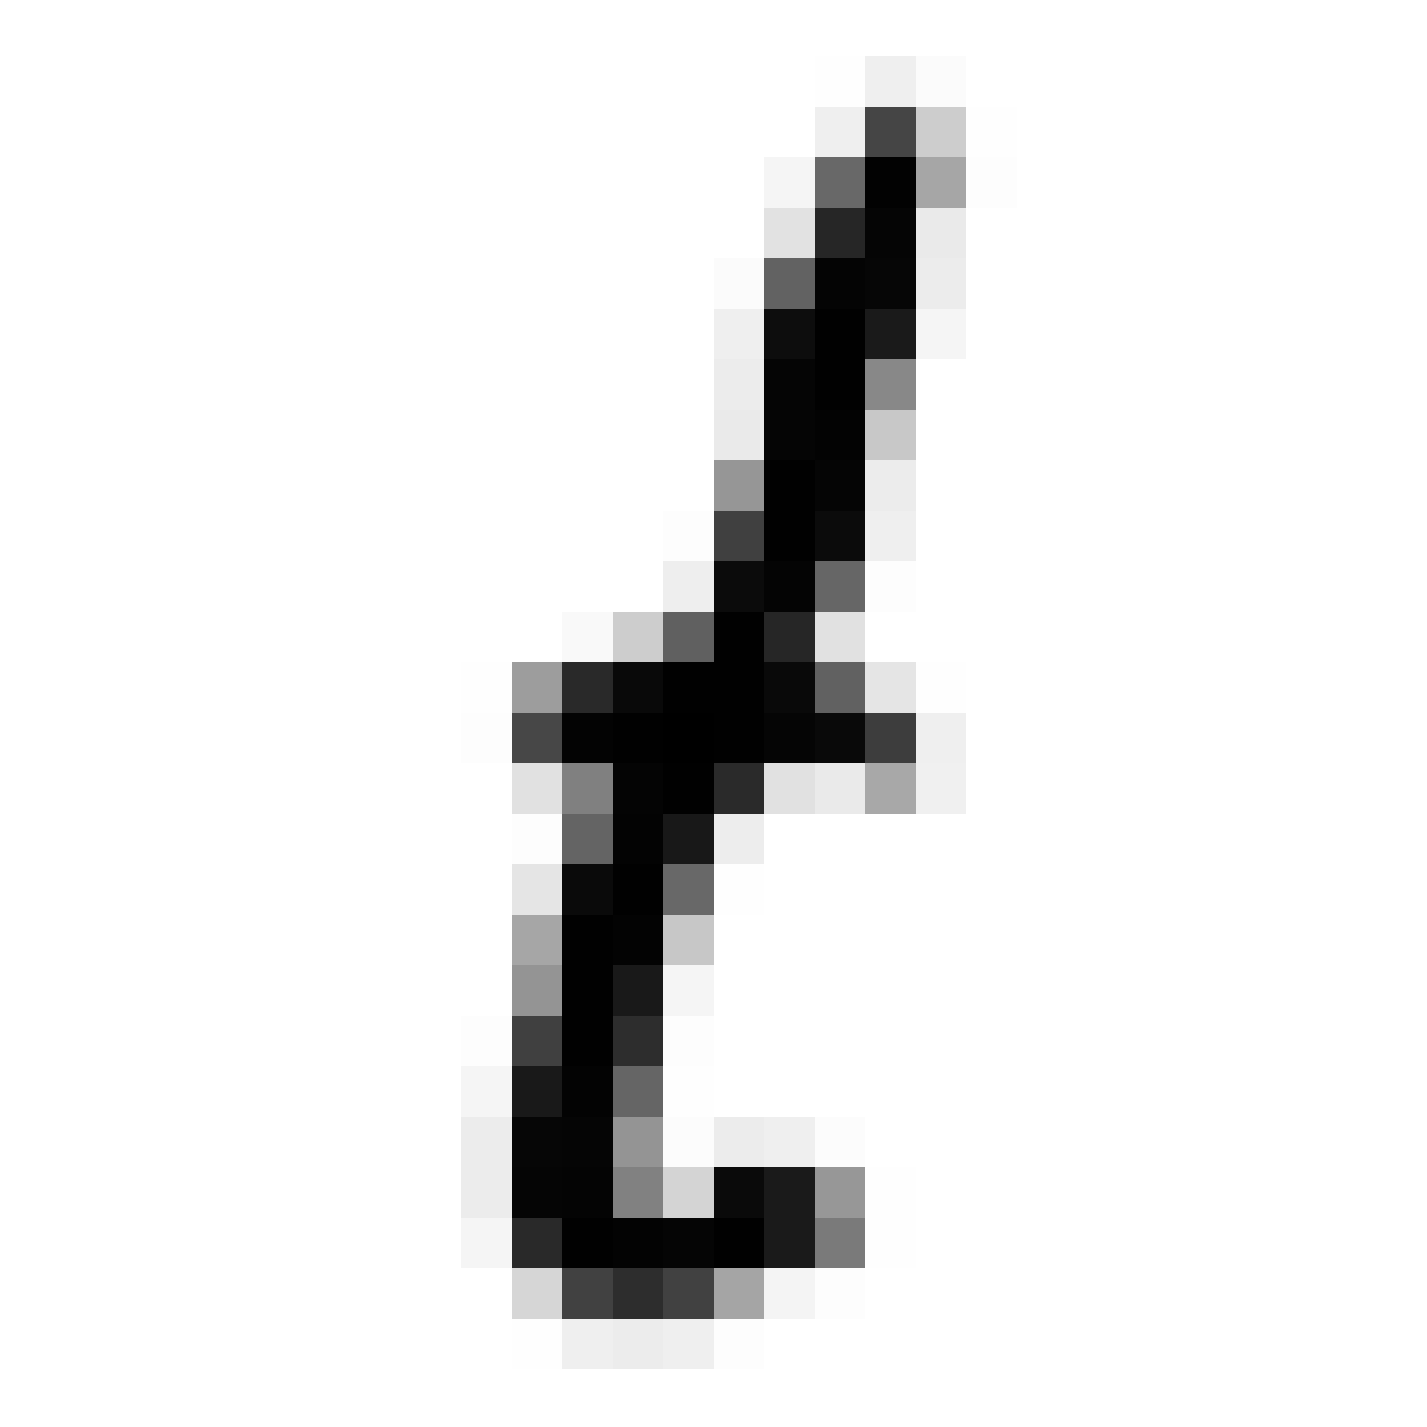

In [13]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[2002:2003, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((1, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

displayData(X[2002:2003, :])

<label><p>Bibliografia:</p> 
    <ul>
        <li>
            https://www.thetopsites.net/article/52573858.shtml
        </li>
        <li>
            https://lionbridge.ai/datasets/15-best-ocr-handwriting-datasets/
        </li>
        <li>
            https://www.nist.gov/itl/products-and-services/emnist-dataset
        </li>
    </ul>
    
</Label>
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 '\n'
a b c d e f g h i j  k  l  m  n  o  p   q  r  s  t